# Assignment 1 2AMM10 2023-2024

## Group: [Fill in your group name]
### Member 1: [Luca Mainardi]
### Member 2: [Francesco Brescia]
### Member 3: [Matthew Nana]

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle


In [3]:
# function for loading the training data:

def load_data(file):
    """
    This function loads the data from the specified pickle file and returns a dictionary with the data
    :param filename: the pickle file
    :return: dict with data -- keys and values differ for the train data and test data for each task.
     Please see the cells with example code below for explanations and examples of the data structure per data set.
    """
    with open(file, 'rb') as f:
        data_dict = pickle.load(f)
    return data_dict

In [4]:
train_data = load_data('data/train_data.pkl')

In [5]:
# the structure of the training data is a dict, where the keys are strings indicating the alphabet.
# The values are again dicts, with the keys being the character and the values being a list of images of that character.

# see the code below for examples of working with the train data

alphabets = list(train_data.keys())


print('example alphabet names:', alphabets[:5])
print('\n')
print('how to get an example image for a specific character:')

alphabet_id = 4
alphabet = alphabets[alphabet_id]  # a dict
characters_for_this_alphabet = list(train_data[alphabet].keys())
character_id = 5
character = characters_for_this_alphabet[character_id]
image_id = 2

print(f'shape of image {image_id} of character {character} of alphabet {alphabet}:', train_data[alphabet][character][image_id].shape)

example alphabet names: ['Alphabet_of_the_Magi', 'Anglo-Saxon_Futhorc', 'Arcadian', 'Armenian', 'Asomtavruli_(Georgian)']


how to get an example image for a specific character:
shape of image 2 of character character06 of alphabet Asomtavruli_(Georgian): torch.Size([1, 105, 105])


In [6]:
# function for plotting some examples:

def plot_example_data(data_dict):
    """
    This function plots some examples of the data
    :param data_dict: dict with as keys a string specifying the alphabet, and as values a dict with as keys the character of the alphabet, and as values a list om images of the alphabet
    """
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    alphabets_to_plot = np.random.choice(list(data_dict.keys()), size=10, replace=False)
    
    for i, alphabet in enumerate(alphabets_to_plot):
        characters = data_dict[alphabet]
        character_to_plot = np.random.choice(list(characters.keys()), size=1)[0]
        images = characters[character_to_plot]
        im_idx = np.random.choice(len(images), size=1)[0]
        axs[i//5, i%5].imshow(images[im_idx].permute(1, 2, 0))
        axs[i//5, i%5].set_title(alphabet + '\n' + character_to_plot, fontsize=8)
        axs[i//5, i%5].axis('off')
    # plt.show()


<Figure size 640x480 with 0 Axes>

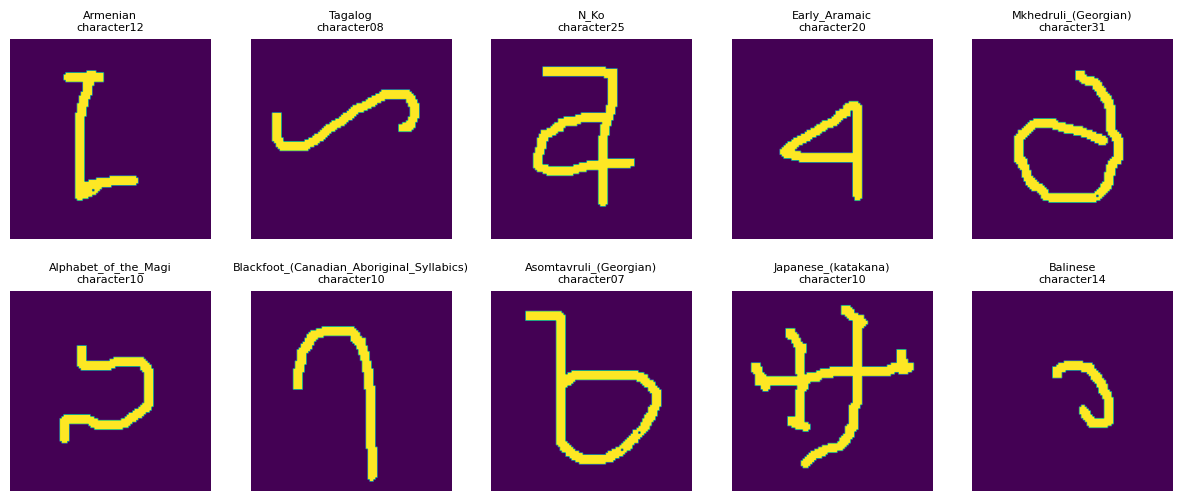

In [7]:
plt.figure()
plot_example_data(train_data)
# plt.savefig('example_data.png', dpi=600)
plt.show()

# Task 1: character recognition

In [86]:
from torch import nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader

In [165]:
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder

class MyDataset(Dataset):
    def __init__(self, data_dict):

        self.images = []
        self.labels = []
        self.encoder = LabelEncoder()

        for alphabet in data_dict.keys():
            characters = data_dict[alphabet]
            for character in characters.keys():
                images = characters[character]
                self.images.extend(images)
                self.labels.extend([f"{alphabet} {character}"] * len(images))

        self.labels = self.encoder.fit_transform(self.labels)

    def __len__(self):
        # l = 0
        # for alphabet in train_data.keys():
        #     characters = train_data[alphabet]
        #     for character in characters.keys():
        #         images = characters[character]
        #         l += len(images)
        # return l
        return len(self.images)
        
    def __getitem__(self, idx):

        if idx >= len(self):
            raise IndexError
        
        image = self.images[idx]
        # clone the channels to have 3 channels
        image = torch.cat([image, image, image], dim=0)
        label = self.labels[idx]

        assert image.shape == (3, 105, 105)

        # make image smaller in size TODO
        image = nn.functional.interpolate(image.unsqueeze(0), size=(64, 64), mode='bilinear', align_corners=True).squeeze(0)
        

        return image, label
        # for alphabet in train_data.keys():
        #     characters = train_data[alphabet]
        #     for character in characters.keys():
        #         images = characters[character]
        #         if idx < len(images):
        #             image = images[idx]
        #             return image, f"{alphabet} {character}"
        #         idx -= len(images)
        

In [166]:
# Instantiate the dataset
trainset = MyDataset(train_data)

In [167]:
len(trainset)

19280

In [168]:
trainset[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 0)

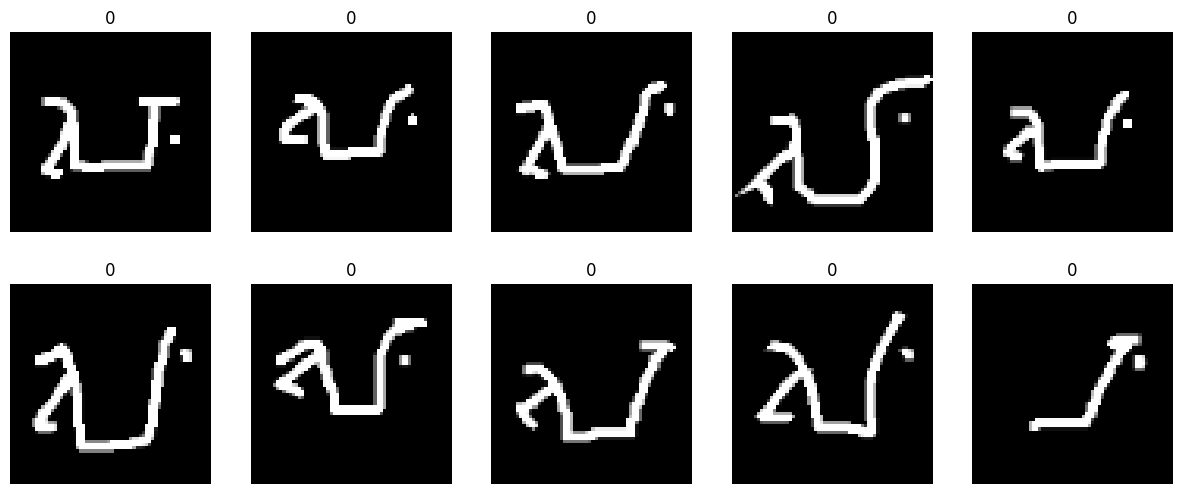

In [169]:
# plot some images from the dataset
plt.figure(figsize=(15, 6))
for i in range(10):
    image, label = trainset[i]
    plt.subplot(2, 5, i+1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title(label)
    plt.axis('off')

In [184]:
num_classes = len(set(trainset.labels))
num_classes

964

In [220]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from PIL import Image
import tqdm
import os

In [221]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = nn.functional.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [222]:

# Siamese Network definition
class SiameseNetwork(nn.Module):
    def __init__(self, pretrained=True):
        super(SiameseNetwork, self).__init__()
        self.feature_extractor = self.get_feature_extractor(pretrained)
        self.fc = nn.Linear(512, 128)

    def get_feature_extractor(self, pretrained):
        resnet = resnet18(pretrained=pretrained)
        feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
        return feature_extractor

    def forward_one(self, x):
        return self.feature_extractor(x).squeeze()

    def forward(self, x1, x2):
        output1 = self.forward_one(x1)
        output2 = self.forward_one(x2)
        return output1, output2

# Siamese Dataset definition
class SiameseDataset(Dataset):
    def __init__(self, data_dict, transform=None):
        
        self.images = []
        self.labels = []
        self.transform = transform
        self.encoder = LabelEncoder()

        for alphabet in data_dict.keys():
            characters = data_dict[alphabet]
            for character in characters.keys():
                images = characters[character]
                self.images.extend(images)
                self.labels.extend([f"{alphabet} {character}"] * len(images))

        self.labels = self.encoder.fit_transform(self.labels)


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        img1 = self.images[idx]
        img1 = img1.repeat(3, 1, 1)
        label1 = self.labels[idx]

        # Sample a random image from the same class
        class_images = []
        for i, label in enumerate(self.labels):
            if label == label1:
                class_images.append(self.images[i])
        img2 = class_images[np.random.choice(len(class_images))]
        img2 = img2.repeat(3, 1, 1)

        return img1, img2, torch.tensor(label1)




# # Function to load and preprocess images
# def load_image(image_path):
#     image = Image.open(image_path).convert('RGB')
#     preprocess = transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ])
#     return preprocess(image)

# Function to create Siamese dataset
def create_siamese_dataset(data_dict):
    return SiameseDataset(data_dict=data_dict, transform=transforms.ToTensor())

# Function to train Siamese network
def train_siamese_network(siamese_network, train_loader, num_epochs=10, learning_rate=0.001):
    criterion = ContrastiveLoss()
    optimizer = optim.Adam(siamese_network.parameters(), lr=learning_rate)

    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0
        for img1, img2, label1 in train_loader:
            optimizer.zero_grad()
            output1, output2 = siamese_network(img1, img2)
            loss = criterion(output1, output2, label1)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

# Function to compute similarity between images
def compute_similarity(siamese_network, image1, image2):
    embedding1, embedding2 = siamese_network.forward(image1.unsqueeze(0), image2.unsqueeze(0))
    similarity = torch.cosine_similarity(embedding1, embedding2, dim=1)
    return similarity.item()

# Example usage
siamese_network = SiameseNetwork(pretrained=True)
siamese_dataset = create_siamese_dataset(train_data)
train_loader = DataLoader(siamese_dataset, batch_size=32, shuffle=True)

for img1, img2, label1 in train_loader:
    print(img1.shape, img2.shape, label1.shape)
    break



train_siamese_network(siamese_network, train_loader)

# unlabeled_image1_path = 'path_to_unlabeled_image1.jpg'
# unlabeled_image2_path = 'path_to_unlabeled_image2.jpg'
# image1 = load_image(unlabeled_image1_path)
# image2 = load_image(unlabeled_image2_path)
# similarity = compute_similarity(siamese_network, image1, image2)
# print("Similarity between images:", similarity)


/Users/lucamainardi/.pyenv/versions/3.11.0/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/lucamainardi/.pyenv/versions/3.11.0/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([32, 3, 105, 105]) torch.Size([32, 3, 105, 105]) torch.Size([32])


TypeError: 'module' object is not callable

In [183]:
from torchvision.models import resnet50

class MyModel(nn.Module):
    def __init__(self, num_classes=1000):
        super(MyModel, self).__init__()
        self.resnet = resnet50(pretrained=True)
        self.resnet.fc = nn.Linear(2048, num_classes)
    
    def forward(self, x):
        return self.resnet(x)

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            output = self.forward(x.unsqueeze(0))
            pred = torch.argmax(output, dim=1)
        return pred

In [187]:
# Define the model
model = MyModel(num_classes=num_classes)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)  # Replace the last layer


AttributeError: 'MyModel' object has no attribute 'fc'

In [172]:
# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [173]:
from tqdm import tqdm

In [174]:
num_epochs = 5
batch_size = 64
# Training loop for the large dataset
for epoch in tqdm(range(num_epochs)):
    for i, (images, labels) in enumerate(DataLoader(trainset, batch_size=batch_size)):
        # Forward pass
        outputs = model(images)
        #labels = torch.tensor(labels)        
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  0%|          | 0/5 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [156]:
# predict on the first image
model.eval()
with torch.no_grad():
    image, label = trainset[15000]
    output = model(image.unsqueeze(0))
    pred = torch.argmax(output, dim=1)
    print(f"Predicted: {trainset.encoder.inverse_transform(pred)}, True: {trainset.encoder.inverse_transform([label])}")

Predicted: ['Japanese_(hiragana) character25'], True: ['Mkhedruli_(Georgian) character12']


In [178]:
# load the test data:

data_dict_test = load_data('data/test_data_task1.pkl')
# keys are 'annotated_images', 'annotated_images_labels', 'unseen_images', 'unseen_images_labels'.
# These keys correspond to the annotated images with known labels for each test alphabet (the sets A);
# labels of the images with known labels for each test alphabet;
# to-be-labeled unseen images for each test alphabet (sets U);
# and labels of the to-be-labeled unseen images for each alphabet, respectively.
# For each alphabet, the labels of the unseen images should be predicted by the model.
# The true labels of the unseen images can only be used to calculate evaluation metrics.
print(data_dict_test.keys())


dict_keys(['annotated_images', 'annotated_images_labels', 'unseen_images', 'unseen_images_labels'])


In [179]:
# example: let's get some annotated images and their labels for an alphabet in the test data:

alphabets_test = list(data_dict_test['annotated_images'].keys())
alphabet_id = np.random.randint(0, len(alphabets_test))
alphabet = alphabets_test[alphabet_id]

alphabet_annotated = data_dict_test['annotated_images'][alphabet]  # a tensor of shape (num_images, 1, height, width)
print(f'Shape of {alphabet} annotated images:', alphabet_annotated.shape)

alphabet_annotated_labels = data_dict_test['annotated_images_labels'][alphabet]  # a list of length num_images
print(f'Number of {alphabet} annotated labels:', len(alphabet_annotated_labels))  # equals num_images

alphabet_unseen = data_dict_test['unseen_images'][alphabet]  # a tensor of shape (num_images, 1, height, width)
print(f'Shape of {alphabet} unseen images:', alphabet_unseen.shape)

alphabet_unseen_labels = data_dict_test['unseen_images_labels'][alphabet]  # a list of length num_images
print(f'Number of {alphabet} unseen labels: {len(alphabet_unseen_labels)}. Use the unseen labels only for evaluating your model!')  # equals num_images

Shape of Manipuri annotated images: torch.Size([40, 1, 105, 105])
Number of Manipuri annotated labels: 40
Shape of Manipuri unseen images: torch.Size([760, 1, 105, 105])
Number of Manipuri unseen labels: 760. Use the unseen labels only for evaluating your model!


In [180]:
num_classes_test = len(set(alphabet_annotated_labels))
num_classes_test

40

In [ ]:

# evaluation of the model:

# Task 2: rotation problem

In [ ]:
# load the test data for task 2:
# the structure of the test data of task 2 is exactly the same as for task 1,
# but now the images are rotated by an unknown angle between 0 and 360 degrees.
data_dict_test_task2 = load_data('test_data_task2.pkl')

In [ ]:
data_dict_test_task2.keys()

In [ ]:
# solution and evaluation of task 2:

# Task 3: Domain knowledge injection

In [ ]:
# load the test data for task 3:
# the structure of the data of task 3 is exactly the same as for task 1, but now our the loaded dictionary contains some additional keys.
# These additional keys will be explained in the cells below:

data_dict_test_task3 = load_data('test_data_task3.pkl')
print(data_dict_test_task3.keys())

In [ ]:
# The keys 'annotated_images', 'annotated_images_labels', 'unseen_images', 'unseen_images_labels' are the same as for task 1, and the structure of the data is exactly the same. 

# The key 'unseen_images_preceding_types' maps to the type of the preceding character in the sequence where the unseen image was observed, for each alphabet.
# The key 'character_to_type_mapping' maps to the mapping of each character to its type, for each alphabet.
# The key 'type_following_probs' maps to the probabilities of each character type being followed by another character type, for each alphabet.

In [ ]:
# examples:

alphabet = np.random.choice(list(data_dict_test_task3['unseen_images_preceding_types'].keys()))
print(f'Alphabet: {alphabet}')


preceding_character_types_alphabet = data_dict_test_task3["unseen_images_preceding_types"][alphabet]  # a list
print(f'Some character types that preceded unseen images from the {alphabet} alphabet: {np.random.choice(preceding_character_types_alphabet, size=5)}')
print(f'There are {len(preceding_character_types_alphabet)} preceding character types in the {alphabet} alphabet, and {len(data_dict_test_task3["unseen_images"][alphabet])} unseen images.')


character_to_type_mapping_alphabet = data_dict_test_task3["character_to_type_mapping"][alphabet]  
# this is a dict, with as keys the characters and as values the types
random_character = np.random.choice(list(character_to_type_mapping_alphabet.keys()))
print(f'Type of {random_character} from the {alphabet} alphabet: {character_to_type_mapping_alphabet[random_character]}')



type_following_probs_alphabet = data_dict_test_task3["type_following_probs"][alphabet]  # a dict of dicts
preceding_type = np.random.choice(list(type_following_probs_alphabet.keys()))
following_type = np.random.choice(list(type_following_probs_alphabet[preceding_type].keys()))
print(f'Probability of a character of type {following_type} following a character of type {preceding_type} in the {alphabet} alphabet: {type_following_probs_alphabet[preceding_type][following_type]}')
